In [2]:
require(data.table)
require(tidyverse)

## 1. Read data 

In [4]:
dat.mat <- fread('../dat/1901/alpha_beta.promoter.long_matrix_w_transcripts.txt')
dim(dat.mat)
head(dat.mat)
#dat.mat$cell <- NULL #no need cell id 

# get all cells 
dat.all.cells <- table((fread('../dat/output.umap.ab.filtered.csv'))$cluster) # table for all cells
dat.all.cells
sum(dat.all.cells)
length(unique(dat.mat$cell))

# prepare data
dat.mat.transcript_level <- dat.mat%>%
    select(-one_of("seq","start","end"))%>%
    distinct()%>%
    select(-cell)%>%
    unite("gene_tr.idx",c("gene","transcript.idx"),remove = T)%>%
    separate(cluster,into = c("cluster","sub"))%>%
    select(-sub)

#rm(dat.mat)
#head(dat.mat.transcript_level)
#dim(dat.mat.transcript_level)


[1] 19412387        7

seq,start,end,gene,cluster,cell,transcript.idx
chr1,859052,860562,SAMD11,alpha_1,Islet1-fresh_AGACACCTAGGCAGAAGTAAGGAGCAGGA,7
chr1,859052,860562,SAMD11,alpha_1,Islet1-fresh_AGACACCTATGCGCAGCGTCTAATGGTTG,7
chr1,859052,860562,SAMD11,alpha_2,Islet1-fresh_AGACACCTCGAGGCTGAAGGCTATGGTTG,7
chr1,859052,860562,SAMD11,alpha_2,Islet1-fresh_AGACACCTCGTACTAGCTAAGCCTGTACT,7
chr1,859052,860562,SAMD11,alpha_1,Islet1-fresh_AGACACCTGGACTCCTTCGACTAGGGTTG,7
chr1,859052,860562,SAMD11,alpha_2,Islet1-fresh_AGACACCTGGAGCTACAAGGAGTAAGGCG,7



alpha_1 alpha_2  beta_1  beta_2 
   4266    1328    4354    2816 

[1] 12764

[1] 12764

gene_tr.idx,cluster
SAMD11_7,alpha_1
SAMD11_7,alpha_1
SAMD11_7,alpha_2
SAMD11_7,alpha_2
SAMD11_7,alpha_1
SAMD11_7,alpha_2


[1] 19381542        2

#### 2.2.2 Handle these special cases by cat gene and tr.idx

## 3. Fisher's exact test at transcript level 

As long as there is any promoter peaks in that cell, the gene's promoter is open. 

Compare alpha and beta

In [9]:
dat.all.cells['alpha']<- dat.all.cells['alpha_1'] + dat.all.cells['alpha_2']
dat.all.cells['beta'] <- dat.all.cells['beta_1'] + dat.all.cells['beta_2']
dat.all.cells

alpha_1 alpha_2  beta_1  beta_2   alpha    beta 
   4266    1328    4354    2816    5594    7170 

In [21]:
fun.ftestPerTr <- function(  tr='SAMD11_7',#=1
                             dat=dat.mat.transcript_level){
    
    celltypes=c('alpha','beta')
    test.dat <- table((dat.mat.transcript_level%>% filter(gene_tr.idx==tr))$cluster)
    table.res <- as.vector(test.dat)
    names(table.res) <- names(test.dat)
    
    # handle if 0 for one subtype 
    a=setdiff(celltypes,    names(table.res))
    table.res[a]<-0
    
    test.tab <- matrix(c(table.res[celltypes[1]], table.res[celltypes[2]], 
                         dat.all.cells[celltypes[1]]-table.res[celltypes[1]], 
                         dat.all.cells[celltypes[2]]-table.res[celltypes[2]]),
                       byrow =  T,       
                       nrow = 2,
                       dimnames = list(expressed = c("Yes", "No"),
                       subtype = celltypes))

    f1<-test.tab[1]/(test.tab[1]+test.tab[2])
    f2 <- test.tab[3]/(test.tab[3]+test.tab[4])
    l <-ifelse(f1>f2,'greater','less')
    test.res <- fisher.test(test.tab,alternative = l)
    res <- list(pval=test.res$p.value,
                odds=test.res$estimate,
                type1_frac=f1,
                type2_frac=f2
               )
    res
}

##

#fun.ftestPerGene(dat = dat.sub,tr=1)
system.time(fun.ftestPerTr())
fun.ftestPerTr()


   user  system elapsed 
  0.155   0.004   0.162 

$pval
[1] 8.684406e-09

$odds
odds ratio 
 0.5545025 

$type1_frac
[1] 0.02323918

$type2_frac
[1] 0.04114365

In [22]:
# time consumming task
system.time({
    require(parallel)   
    all.tr <- unique(dat.mat.transcript_level$gene_tr.idx)
    res.ab.transcript_level <- mclapply(all.tr,function(trr) 
        fun.ftestPerTr(tr = trr),mc.cores = 10)
})
        

Loading required package: parallel


    user   system  elapsed 
4851.340  627.839  702.340 

In [26]:
# convert to df
res.ab.transcript_level <- do.call(rbind,res.ab.transcript_level)
rownames(res.ab.transcript_level) <- all.tr
 res.ab.transcript_level <- as.data.frame(res.ab.transcript_level)


# adjust for p value 
m<- c("fdr","bonferroni","BY");
names(m)<-c("FDR","padj.Bonferroni","FDR.BY")
for(i in 1:3){
    res.ab.transcript_level[[names(m)[i]]] <- p.adjust(as.numeric(res.ab.transcript_level$pval),method = m[i])
}
res.ab.transcript_level$odds <- as.numeric(res.ab.transcript_level$odds)
head(res.ab.transcript_level)


,pval,odds,type1_frac,type2_frac
SAMD11_7,8.684406e-09,0.5545025,0.02323918,0.04114365
SAMD11_13,7.469441e-35,0.2118863,0.009831963,0.04476987
SAMD11_14,5.063541e-154,0.1121893,0.0178763,0.1396095
NOC2L_19,0.1346232,1.110686,0.04165177,0.0376569
KLHL17_23,0.3256967,1.085713,0.01376475,0.01269177
PLEKHN1_27,0.404295,0.9580591,0.01698248,0.01771269


In [31]:
saveRDS(res.ab.transcript_level,"../dat/1901/res.ab.transcript_level.df.rds")

## threholding

In [1]:
res.ab.transcript_level <- readRDS("../dat/1901/res.ab.transcript_level.df.rds")

Loading required package: ggplot2


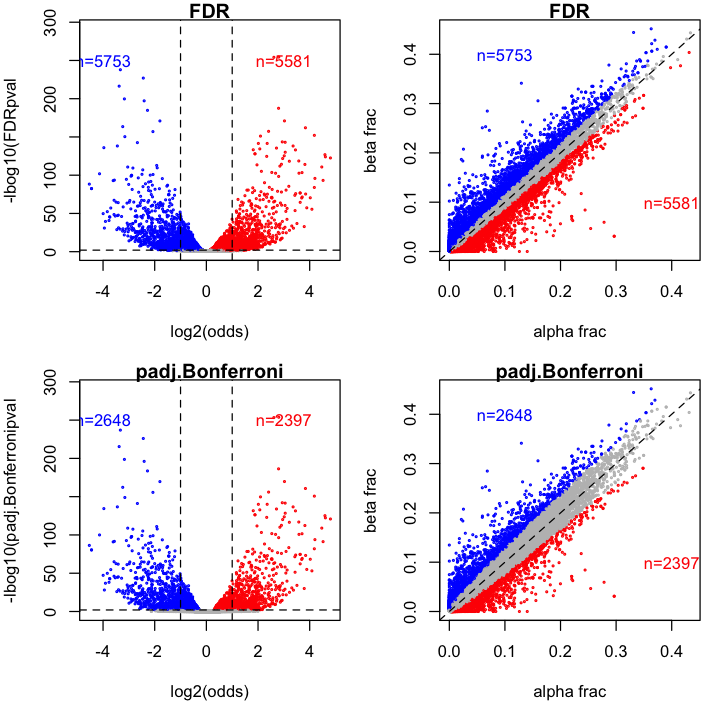

In [2]:
options(repr.plot.width=6, repr.plot.height=6)
# without ODDs threshold
require(ggplot2)
options(repr.plot.width=6, repr.plot.height=6)

res.genes_level.a.df <- res.ab.transcript_level
par(mar=c(5,4,1,1),mfrow = c(2,2))
for(m in c("FDR","padj.Bonferroni")){
    up<- res.genes_level.a.df[,m] <0.01 & res.genes_level.a.df[,"odds"]>1
    down<-res.genes_level.a.df[,m] <0.01 & res.genes_level.a.df[,"odds"]<1
plot(x=log2(res.genes_level.a.df$odds),y=-log10(as.numeric(res.genes_level.a.df[,m])),
     xlab = "log2(odds)",ylab=paste0('-lbog10(',m,'pval'),cex=.25,
     col=ifelse(up,"red",ifelse(down,"blue","grey")),
     main = m)
abline(h = 2,col=1,lty=2)
abline(v=c(-1,1),col=1,lty=2)
text(-4,250,col='blue',labels = paste0("n=",sum(down)))
text(3,250,col='red',labels = paste0("n=",sum(up)))

# scatter 
plot(x=as.numeric(res.genes_level.a.df$type1_frac),y=as.numeric(res.genes_level.a.df$type2_frac),
     xlab = "alpha frac",ylab='beta frac',cex=.25,
     col=ifelse(up,"red",ifelse(down,"blue","grey")),
     main = m)
abline(a=0,b = 1,col=1,lty=2)
text(.1,.4,col='blue',labels = paste0("n=",sum(down)))
text(.4,.1,col='red',labels = paste0("n=",sum(up)))
}

In [35]:
binary.glist <- list()
m<-"padj.Bonferroni"

up<- res.genes_level.a.df[,m] <0.01 & res.genes_level.a.df[,"odds"]>1
down<-res.genes_level.a.df[,m] <0.01 & res.genes_level.a.df[,"odds"]<1
binary.glist$alpha_tr <- rownames(res.genes_level.a.df)[up]
binary.glist$alpha <- sapply(rownames(res.genes_level.a.df)[up],function(x) unlist(strsplit(x,split = "_"))[1])
binary.glist$beta <- sapply(rownames(res.genes_level.a.df)[down],function(x) unlist(strsplit(x,split = "_"))[1])
binary.glist$beta_tr <- rownames(res.genes_level.a.df)[down]                             

binary.glist$alpha <- unique(binary.glist$alpha)
binary.glist$beta <- unique(binary.glist$beta)

## beta                             
t(unlist(lapply(binary.glist,length)))

alpha_tr,alpha,beta,beta_tr
2397,2053,2199,2648


## Go term

In [38]:
require(enrichR)
dbs <- listEnrichrDbs()
#dbs%>% filter(grepl('KEGG',libraryName) | grepl("GO_Biological_Process",libraryName))
binary.glist.enrichR <- list()
for(i in c("alpha","beta")){
    binary.glist.enrichR[[i]] <- enrichr(binary.glist[[i]], c("GO_Biological_Process_2018","KEGG_2016"))
}

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
  Querying KEGG_2016... Done.
Parsing results... Done.
Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2018... Done.
  Querying KEGG_2016... Done.
Parsing results... Done.


In [ ]:
require(biomaRt)
ensembl = useEnsembl(biomart="ensembl", dataset="hsapiens_gene_ensembl")
for(i in c("alpha","beta")){
    fn <- paste0("../dat/1901/glist_",i,".csv")
    fwrite(getBM(attributes=c('ensembl_gene_id','hgnc_symbol'), 
                 filters ='hgnc_symbol', values = binary.glist[[i]] , mart = ensembl),file=fn)
}

####  alpha

In [42]:
# c1.1
head(binary.glist.enrichR$alpha$GO_Biological_Process_2018%>%arrange(desc(Combined.Score)),n=20)%>%select(-starts_with("Old"))
head(binary.glist.enrichR$alpha$GO_Biological_Process_2018%>%arrange(Adjusted.P.value),n=20)%>%select(-starts_with("Old"))
head(binary.glist.enrichR$alpha$KEGG_2016%>%arrange(desc(Combined.Score)),n=20)%>%select(-starts_with("Old"))
head(binary.glist.enrichR$alpha$KEGG_2016%>%arrange(Adjusted.P.value),n=20)%>%select(-starts_with("Old"))


Term,Overlap,P.value,Adjusted.P.value,Z.score,Combined.Score,Genes
peptidyl-tyrosine modification (GO:0018212),19/52,4.117149e-07,2.980810e-04,-1.841589,27.07677,CSF1R;EPHA4;SRC;INSR;FLT4;PDGFB;TTBK1;FER;RELN;TEC;ERBB4;ABI1;PTK2B;FYN;FGFR4;EPHB2;FGFR3;FGFR2;EPHA3
cardiac atrium development (GO:0003230),5/8,4.865888e-04,3.324501e-02,-3.508140,26.76041,DLL4;NOTCH1;NPHP3;ANK2;ENG
positive regulation of ERK1 and ERK2 cascade (GO:0070374),45/202,4.222111e-07,2.980810e-04,-1.714082,25.15889,EPHB6;RET;NECAB2;CCL14;CSF1R;NRP1;NOTCH1;ARHGAP8;FLT4;PDGFB;ARRB1;PRKCZ;CX3CL1;CTGF;CCL15-CCL14;ERBB3;ERBB4;PDGFD;GPER1;GCNT2;PTK2B;CD36;EPHB2;PDE8A;EPHB1;HRAS;CCL15;EPHA5;EPHA4;FGA;NTRK2;CD74;EPHA7;INSR;F2R;OPRM1;NPNT;BMP2;AXL;F2RL1;PRKD2;FGFR4;FGFR3;FGFR2;EPHA3
actin filament bundle organization (GO:0061572),15/36,9.626754e-07,5.097366e-04,-1.815096,25.14552,USH1C;PAWR;NEDD9;RHOC;ESPN;RND3;AIF1;RHOBTB1;RHOB;RND1;EPS8;LIMA1;BAIAP2L2;FSCN1;PLS3
positive regulation of cell migration (GO:0030335),46/222,2.687877e-06,1.265094e-03,-1.907884,24.47197,RET;CSF1R;NRP1;DOCK5;NOTCH1;SRC;SEMA3D;SEMA3A;LEF1;PDGFB;PIK3CD;SEMA3E;MYLK;DDRGK1;PDGFD;FAM110C;GPER1;NTF3;ZNF703;GCNT2;ENPP2;PTK2B;DRD1;RREB1;HRAS;SEMA4A;SEMA6A;F10;INSR;SPHK1;PRKCE;ARHGEF39;F2R;GAB1;LAMB1;SEMA4G;SOD2;RAB11A;VIL1;BMP2;DAB2;FER;F2RL1;FGFR1OP;PFN1;DOCK1
positive regulation of metanephros development (GO:0072216),5/9,1.002126e-03,4.614137e-02,-3.343109,23.08628,RET;PAX8;MYC;LIF;PDGFB
regulation of NMDA receptor activity (GO:2000310),8/14,2.067784e-05,3.244124e-03,-2.124821,22.91927,CRHBP;RELN;DAPK1;DLG4;CRH;PTK2B;OPRM1;EPHB2
regulation of cell migration (GO:0030334),66/317,1.648265e-08,6.982049e-05,-1.273251,22.81787,RET;CLIC4;SERPINE2;PIK3CD;LDB2;RND3;CX3CL1;RND1;MYLK;ROBO1;SHH;FAM110C;GPER1;ENPP2;PLXNC1;HRAS;SPHK1;F2R;RHOC;GTPBP4;RHOB;TMEFF2;NAV3;SPATA13;ENG;CSF1R;KANK1;NOTCH1;SRC;SEMA3D;SEMA3A;LEF1;PDGFB;SEMA3E;RHOBTB1;ERBB4;DDRGK1;PDGFD;LMNA;GNA12;NTF3;ZNF703;GCNT2;PTK2B;DRD1;SEMA4A;JAG1;ACE;F10;INSR;ARHGEF39;LAMB1;SEMA4G;SOD2;SORL1;SMAD7;VIL1;BMP2;DAB2;FER;PLXNB3;F2RL1;FGFR1OP;AMOTL2;PLXNB1;AMOTL1
axon guidance (GO:0007411),38/159,5.176656e-07,3.132616e-04,-1.567562,22.68879,RET;SPON2;NRP1;ROBO3;SPTBN4;SRC;SH3KBP1;SEMA3A;PIK3CD;PTPRM;PIK3R1;RAP1GAP;ROBO1;SHH;RELN;GPC1;NCAM1;FYN;PLXNC1;EPHB2;EPHB1;HRAS;PDLIM7;VASP;EPHA5;EPHA4;SEMA6A;DCC;WNT5A;GAB1;EFNA1;EFNA2;DOK4;FEZ1;DOK6;PLXNB3;PLXNB1;CNTN4
positive regulation of macromolecule metabolic process (GO:0010604),53/277,5.949761e-06,1.680213e-03,-1.833048,22.05552,PIK3CD;ARRB1;CLU;MYC;GPER1;ITGB8;CD36;EPHB2;BVES;SCYL2;TLE1;DTX3L;SLC11A1;WNT5A;SERPINB9;PAX6;ANK2;MITF;SOX11;NGF;HCFC1;GREM1;TBC1D5;RNF207;PKP3;VSTM2A;DNMT1;LEF1;PDGFB;TTBK1;DLL4;MAPK8;INPP5F;DDRGK1;NTF3;UBR5;DRD1;STOX1;SNCA;SRPK2;TFAP2A;SEC16B;MBD4;NTRK2;VDR;NR0B2;KLF2;BMP4;BMP2;UBAP2;HOXD3;FGFR4;HSPA1A


Term,Overlap,P.value,Adjusted.P.value,Z.score,Combined.Score,Genes
regulation of cell migration (GO:0030334),66/317,1.648265e-08,6.982049e-05,-1.273251,22.81787,RET;CLIC4;SERPINE2;PIK3CD;LDB2;RND3;CX3CL1;RND1;MYLK;ROBO1;SHH;FAM110C;GPER1;ENPP2;PLXNC1;HRAS;SPHK1;F2R;RHOC;GTPBP4;RHOB;TMEFF2;NAV3;SPATA13;ENG;CSF1R;KANK1;NOTCH1;SRC;SEMA3D;SEMA3A;LEF1;PDGFB;SEMA3E;RHOBTB1;ERBB4;DDRGK1;PDGFD;LMNA;GNA12;NTF3;ZNF703;GCNT2;PTK2B;DRD1;SEMA4A;JAG1;ACE;F10;INSR;ARHGEF39;LAMB1;SEMA4G;SOD2;SORL1;SMAD7;VIL1;BMP2;DAB2;FER;PLXNB3;F2RL1;FGFR1OP;AMOTL2;PLXNB1;AMOTL1
peptidyl-tyrosine modification (GO:0018212),19/52,4.117149e-07,2.980810e-04,-1.841589,27.07677,CSF1R;EPHA4;SRC;INSR;FLT4;PDGFB;TTBK1;FER;RELN;TEC;ERBB4;ABI1;PTK2B;FYN;FGFR4;EPHB2;FGFR3;FGFR2;EPHA3
positive regulation of ERK1 and ERK2 cascade (GO:0070374),45/202,4.222111e-07,2.980810e-04,-1.714082,25.15889,EPHB6;RET;NECAB2;CCL14;CSF1R;NRP1;NOTCH1;ARHGAP8;FLT4;PDGFB;ARRB1;PRKCZ;CX3CL1;CTGF;CCL15-CCL14;ERBB3;ERBB4;PDGFD;GPER1;GCNT2;PTK2B;CD36;EPHB2;PDE8A;EPHB1;HRAS;CCL15;EPHA5;EPHA4;FGA;NTRK2;CD74;EPHA7;INSR;F2R;OPRM1;NPNT;BMP2;AXL;F2RL1;PRKD2;FGFR4;FGFR3;FGFR2;EPHA3
nervous system development (GO:0007399),82/456,3.052784e-07,2.980810e-04,-1.324628,19.87213,TRIM71;CHRM1;GDA;STMN3;RAPGEFL1;NRGN;ROBO1;FGF5;SHH;SALL3;SALL4;DPF1;ENC1;JARID2;EPHB2;EPHB1;DACT1;CSGALNACT1;PCDHGA7;TRPC5;SEMA6A;DSCAM;PAX6;NGF;ALDH5A1;ADORA2A;PAX8;NAV3;NINJ2;FEZ1;SCN8A;MPPED2;NBL1;DSCAML1;SHANK2;HDAC4;NLGN2;SRC;FUT10;GSTP1;CLN8;TRAK1;TRAK2;SNTG2;RELN;PTPRZ1;ERBB3;PCDHA1;ERBB4;SLITRK1;BTBD3;BTBD2;ADAM23;NTF3;MBP;FYN;DRD1;CAMK2G;FARP1;MBD5;JAG1;BCL11A;ZBTB16;POU6F2;CRIM1;PCDHB15;BTBD11;PCDHB12;PCDHB11;SDK1;MAFB;DLG4;PMP22;PCDHB4;CNTN4;FGFR4;NEUROG1;FGF12;FGFR2;PCDHB8;NEUROG3;PCDHB7
actin filament bundle assembly (GO:0051017),16/38,3.516748e-07,2.980810e-04,-1.307995,19.43754,USH1C;PAWR;NEDD9;PDXP;RHOC;ESPN;RND3;AIF1;RHOBTB1;RHOB;RND1;EPS8;LIMA1;BAIAP2L2;FSCN1;PLS3
regulation of ERK1 and ERK2 cascade (GO:0070372),53/248,1.726815e-07,2.980810e-04,-1.069198,16.64935,EPHB6;RET;NRP1;ARHGAP8;FLT4;ARRB1;CX3CL1;CTGF;GPER1;CD36;EPHB2;PDE8A;EPHB1;HRAS;EPHA5;EPHA4;FGA;EPHA7;LMO3;F2R;OPRM1;NPNT;CNKSR3;PRKD2;EPHA3;NECAB2;CCL14;CSF1R;NOTCH1;RGS14;GSTP1;PDGFB;PRKCZ;CCL15-CCL14;SLC9A3R1;ERBB3;ERBB4;PDGFD;GCNT2;PTK2B;FAM83D;GBP1;CCL15;NTRK2;CD74;INSR;BMP2;AXL;WNK2;F2RL1;FGFR4;FGFR3;FGFR2
axon guidance (GO:0007411),38/159,5.176656e-07,3.132616e-04,-1.567562,22.68879,RET;SPON2;NRP1;ROBO3;SPTBN4;SRC;SH3KBP1;SEMA3A;PIK3CD;PTPRM;PIK3R1;RAP1GAP;ROBO1;SHH;RELN;GPC1;NCAM1;FYN;PLXNC1;EPHB2;EPHB1;HRAS;PDLIM7;VASP;EPHA5;EPHA4;SEMA6A;DCC;WNT5A;GAB1;EFNA1;EFNA2;DOK4;FEZ1;DOK6;PLXNB3;PLXNB1;CNTN4
actin filament bundle organization (GO:0061572),15/36,9.626754e-07,5.097366e-04,-1.815096,25.14552,USH1C;PAWR;NEDD9;RHOC;ESPN;RND3;AIF1;RHOBTB1;RHOB;RND1;EPS8;LIMA1;BAIAP2L2;FSCN1;PLS3
positive regulation of cell migration (GO:0030335),46/222,2.687877e-06,1.265094e-03,-1.907884,24.47197,RET;CSF1R;NRP1;DOCK5;NOTCH1;SRC;SEMA3D;SEMA3A;LEF1;PDGFB;PIK3CD;SEMA3E;MYLK;DDRGK1;PDGFD;FAM110C;GPER1;NTF3;ZNF703;GCNT2;ENPP2;PTK2B;DRD1;RREB1;HRAS;SEMA4A;SEMA6A;F10;INSR;SPHK1;PRKCE;ARHGEF39;F2R;GAB1;LAMB1;SEMA4G;SOD2;RAB11A;VIL1;BMP2;DAB2;FER;F2RL1;FGFR1OP;PFN1;DOCK1
axonogenesis (GO:0007409),46/224,3.468071e-06,1.335523e-03,-1.699767,21.36932,RET;SPON2;NRP1;ROBO3;SPTBN4;ECM2;SRC;SH3KBP1;SEMA3A;PIK3CD;LRRC70;PIK3R1;RAP1GAP;ROBO1;SHH;RELN;SLITRK1;GPC1;NCAM1;FYN;EPHB2;EPHB1;HRAS;PDLIM7;VASP;EPHA5;SEMA6A;AUTS2;DCC;WNT5A;GAB1;WNT7A;CCK;GP5;EFNA1;LRFN5;EFNA2;DOK4;FEZ1;DOK6;PLXNB3;LRRN1;PLXNB1;CNTN4;DSCAML1;FGFR2


Term,Overlap,P.value,Adjusted.P.value,Z.score,Combined.Score,Genes
Rap1 signaling pathway_Homo sapiens_hsa04015,46/211,6.073053e-07,0.000173082,-1.961363,28.075403,CSF1R;DOCK4;RGS14;SRC;FLT4;LPAR1;ADCY4;PDGFB;PIK3CD;ADCY2;PIK3R1;ITGAL;ADCY7;PRKCZ;SIPA1L3;RAP1GAP;FGF5;CNR1;PDGFD;PLCE1;HRAS;VASP;PRKCG;INSR;F2R;VEGFC;NGF;GRIN1;APBB1IP;EFNA1;KITLG;EFNA2;ADCY9;ADORA2A;PRKD3;FGF18;GNAS;PRKD2;FGFR4;PLCB1;PFN1;FGFR3;FGF12;FGFR2;SIPA1;RAPGEF4
Pathways in cancer_Homo sapiens_hsa05200,68/397,1.645018e-05,0.002344151,-2.083086,22.945552,RET;WNT2B;CDKN1B;PIK3CD;GLI3;FGF5;SHH;MECOM;MYC;HRAS;JAK1;PRKCG;ARHGEF12;DAPK1;DCC;PLEKHG5;DAPK3;F2R;WNT5A;FLT3LG;MITF;AR;ADCY9;PAX8;COL4A2;COL4A4;COL4A3;PPARG;PLCB1;BIRC3;CSF1R;CTBP2;CTBP1;GSTP1;PTGER3;LEF1;LPAR1;ADCY4;PDGFB;ADCY2;PIK3R1;ADCY7;MAPK8;GNA12;CTNNA1;GNG8;VHL;TCF7L2;EGLN2;LAMB3;ZBTB16;PTCH1;LAMB4;WNT7A;VEGFC;LAMB1;MAPK10;BMP4;BMP2;KITLG;FGF18;BCL2;GNAS;CYCS;GNB5;FGFR3;FGF12;FGFR2
Alcoholism_Homo sapiens_hsa05034,37/179,2.591476e-05,0.002461902,-1.852840,19.567280,HDAC4;HIST1H2BO;MAOB;HIST1H2BJ;HIST1H3J;MAOA;HIST1H2BK;HDAC7;HIST1H3A;HIST1H2AE;GNG8;HIST1H2AG;DRD1;HIST1H3B;HRAS;HIST1H2AB;HIST1H2AM;NTRK2;HIST1H2AL;H3F3B;HIST1H2AH;GRIN1;GRIN3B;HIST1H4A;GRIN3A;HIST1H4B;ADORA2A;GNAS;CRH;HIST1H4I;GNB5;HIST1H2BG;HIST1H2BB;HIST1H4D;HIST1H2BA;HIST1H4E;HIST1H2BD
cAMP signaling pathway_Homo sapiens_hsa04024,39/199,5.574807e-05,0.003177640,-1.841165,18.033601,GRIA1;CHRM1;GPR119;PTGER3;ADCY4;PIK3CD;ADCY2;ADRB1;PIK3R1;HTR4;ADCY7;GLI3;MAPK8;PLCE1;TNNI3;DRD1;CAMK2G;ABCC4;GABBR1;HTR1F;PDE4D;PTCH1;F2R;ATP2B4;RRAS2;SSTR1;ATP1B1;SSTR2;GRIN1;MAPK10;GRIN3B;GRIN3A;ADCY9;ADORA2A;FXYD1;GNAS;ORAI1;GHRL;RAPGEF4
Systemic lupus erythematosus_Homo sapiens_hsa05322,30/135,3.549696e-05,0.002529158,-1.672217,17.133639,HIST1H2BO;HIST1H2BJ;HIST1H3J;CD80;HIST1H2BK;C3;C8G;HIST1H3A;C6;C7;C9;HIST1H2AE;HIST1H2AG;HIST1H3B;HIST1H2AB;HIST1H2AM;HIST1H2AL;H3F3B;HIST1H2AH;ACTN1;HIST1H4A;HIST1H4B;HLA-DPB1;HIST1H4I;HIST1H2BG;HIST1H2BB;HIST1H4D;HIST1H2BA;HIST1H4E;HIST1H2BD
Axon guidance_Homo sapiens_hsa04360,28/127,7.384010e-05,0.003507405,-1.648153,15.679881,EPHB6;NRP1;ROBO3;SEMA3D;SEMA3A;SEMA3E;RND1;ROBO1;ABLIM1;ABLIM2;FYN;PLXNC1;EPHB2;EPHB1;HRAS;EPHA5;EPHA4;SEMA4A;EPHA7;ARHGEF12;SEMA6A;DCC;SEMA4G;EFNA1;EFNA2;PLXNB3;PLXNB1;EPHA3
Morphine addiction_Homo sapiens_hsa05032,22/91,1.022183e-04,0.004161744,-1.687327,15.503839,PRKCG;GABRB2;GABBR1;PDE1A;PDE4D;CACNA1B;ADCY4;ARRB1;ADCY2;OPRM1;ADCY7;GABRG2;PDE11A;ADCY9;GRK5;GNAS;GNG8;GNB5;DRD1;PDE8B;PDE8A;KCNJ3
Phospholipase D signaling pathway_Homo sapiens_hsa04072,30/144,1.246380e-04,0.004440229,-1.718316,15.447825,DGKG;LPAR1;ADCY4;PDGFB;PIK3CD;ADCY2;PIK3R1;AGPAT1;ADCY7;GRM4;GRM7;PDGFD;GNA12;GRM8;PTK2B;FYN;HRAS;AVPR1B;INSR;SPHK1;F2R;GAB1;RRAS2;DGKZ;KITLG;ADCY9;PPAP2B;GNAS;PLCB1;RAPGEF4
Calcium signaling pathway_Homo sapiens_hsa04020,35/180,1.537243e-04,0.004867937,-1.756201,15.420062,CHRM1;PDE1A;PTGER3;CACNA1B;ITPR1;ADCY4;ADRA1D;ADCY2;ADRB1;HTR4;ADCY7;MYLK;CCKAR;CYSLTR2;ERBB3;ERBB4;PTK2B;PLCE1;DRD1;CAMK2G;PRKCG;AVPR1B;SPHK1;F2R;TACR2;ATP2B4;HTR5A;GRIN1;ADCY9;ADORA2A;STIM1;ADRB3;GNAS;ORAI1;PLCB1
Inflammatory mediator regulation of TRP channels_Homo sapiens_hsa04750,22/98,3.201965e-04,0.009125601,-1.751370,14.092528,PRKCG;SRC;IL1R1;PRKCE;ITPR1;ADCY4;PIK3CD;TRPV3;ALOX12;ADCY2;PIK3R1;NGF;PLA2G6;ADCY7;MAPK10;MAPK8;ASIC4;ADCY9;GNAS;F2RL1;PLCB1;CAMK2G


Term,Overlap,P.value,Adjusted.P.value,Z.score,Combined.Score,Genes
Rap1 signaling pathway_Homo sapiens_hsa04015,46/211,6.073053e-07,0.000173082,-1.9613626,28.075403,CSF1R;DOCK4;RGS14;SRC;FLT4;LPAR1;ADCY4;PDGFB;PIK3CD;ADCY2;PIK3R1;ITGAL;ADCY7;PRKCZ;SIPA1L3;RAP1GAP;FGF5;CNR1;PDGFD;PLCE1;HRAS;VASP;PRKCG;INSR;F2R;VEGFC;NGF;GRIN1;APBB1IP;EFNA1;KITLG;EFNA2;ADCY9;ADORA2A;PRKD3;FGF18;GNAS;PRKD2;FGFR4;PLCB1;PFN1;FGFR3;FGF12;FGFR2;SIPA1;RAPGEF4
Pathways in cancer_Homo sapiens_hsa05200,68/397,1.645018e-05,0.002344151,-2.0830857,22.945552,RET;WNT2B;CDKN1B;PIK3CD;GLI3;FGF5;SHH;MECOM;MYC;HRAS;JAK1;PRKCG;ARHGEF12;DAPK1;DCC;PLEKHG5;DAPK3;F2R;WNT5A;FLT3LG;MITF;AR;ADCY9;PAX8;COL4A2;COL4A4;COL4A3;PPARG;PLCB1;BIRC3;CSF1R;CTBP2;CTBP1;GSTP1;PTGER3;LEF1;LPAR1;ADCY4;PDGFB;ADCY2;PIK3R1;ADCY7;MAPK8;GNA12;CTNNA1;GNG8;VHL;TCF7L2;EGLN2;LAMB3;ZBTB16;PTCH1;LAMB4;WNT7A;VEGFC;LAMB1;MAPK10;BMP4;BMP2;KITLG;FGF18;BCL2;GNAS;CYCS;GNB5;FGFR3;FGF12;FGFR2
Alcoholism_Homo sapiens_hsa05034,37/179,2.591476e-05,0.002461902,-1.8528396,19.567280,HDAC4;HIST1H2BO;MAOB;HIST1H2BJ;HIST1H3J;MAOA;HIST1H2BK;HDAC7;HIST1H3A;HIST1H2AE;GNG8;HIST1H2AG;DRD1;HIST1H3B;HRAS;HIST1H2AB;HIST1H2AM;NTRK2;HIST1H2AL;H3F3B;HIST1H2AH;GRIN1;GRIN3B;HIST1H4A;GRIN3A;HIST1H4B;ADORA2A;GNAS;CRH;HIST1H4I;GNB5;HIST1H2BG;HIST1H2BB;HIST1H4D;HIST1H2BA;HIST1H4E;HIST1H2BD
Systemic lupus erythematosus_Homo sapiens_hsa05322,30/135,3.549696e-05,0.002529158,-1.6722168,17.133639,HIST1H2BO;HIST1H2BJ;HIST1H3J;CD80;HIST1H2BK;C3;C8G;HIST1H3A;C6;C7;C9;HIST1H2AE;HIST1H2AG;HIST1H3B;HIST1H2AB;HIST1H2AM;HIST1H2AL;H3F3B;HIST1H2AH;ACTN1;HIST1H4A;HIST1H4B;HLA-DPB1;HIST1H4I;HIST1H2BG;HIST1H2BB;HIST1H4D;HIST1H2BA;HIST1H4E;HIST1H2BD
cAMP signaling pathway_Homo sapiens_hsa04024,39/199,5.574807e-05,0.003177640,-1.8411651,18.033601,GRIA1;CHRM1;GPR119;PTGER3;ADCY4;PIK3CD;ADCY2;ADRB1;PIK3R1;HTR4;ADCY7;GLI3;MAPK8;PLCE1;TNNI3;DRD1;CAMK2G;ABCC4;GABBR1;HTR1F;PDE4D;PTCH1;F2R;ATP2B4;RRAS2;SSTR1;ATP1B1;SSTR2;GRIN1;MAPK10;GRIN3B;GRIN3A;ADCY9;ADORA2A;FXYD1;GNAS;ORAI1;GHRL;RAPGEF4
Axon guidance_Homo sapiens_hsa04360,28/127,7.384010e-05,0.003507405,-1.6481529,15.679881,EPHB6;NRP1;ROBO3;SEMA3D;SEMA3A;SEMA3E;RND1;ROBO1;ABLIM1;ABLIM2;FYN;PLXNC1;EPHB2;EPHB1;HRAS;EPHA5;EPHA4;SEMA4A;EPHA7;ARHGEF12;SEMA6A;DCC;SEMA4G;EFNA1;EFNA2;PLXNB3;PLXNB1;EPHA3
Morphine addiction_Homo sapiens_hsa05032,22/91,1.022183e-04,0.004161744,-1.6873273,15.503839,PRKCG;GABRB2;GABBR1;PDE1A;PDE4D;CACNA1B;ADCY4;ARRB1;ADCY2;OPRM1;ADCY7;GABRG2;PDE11A;ADCY9;GRK5;GNAS;GNG8;GNB5;DRD1;PDE8B;PDE8A;KCNJ3
Phospholipase D signaling pathway_Homo sapiens_hsa04072,30/144,1.246380e-04,0.004440229,-1.7183157,15.447825,DGKG;LPAR1;ADCY4;PDGFB;PIK3CD;ADCY2;PIK3R1;AGPAT1;ADCY7;GRM4;GRM7;PDGFD;GNA12;GRM8;PTK2B;FYN;HRAS;AVPR1B;INSR;SPHK1;F2R;GAB1;RRAS2;DGKZ;KITLG;ADCY9;PPAP2B;GNAS;PLCB1;RAPGEF4
Calcium signaling pathway_Homo sapiens_hsa04020,35/180,1.537243e-04,0.004867937,-1.7562014,15.420062,CHRM1;PDE1A;PTGER3;CACNA1B;ITPR1;ADCY4;ADRA1D;ADCY2;ADRB1;HTR4;ADCY7;MYLK;CCKAR;CYSLTR2;ERBB3;ERBB4;PTK2B;PLCE1;DRD1;CAMK2G;PRKCG;AVPR1B;SPHK1;F2R;TACR2;ATP2B4;HTR5A;GRIN1;ADCY9;ADORA2A;STIM1;ADRB3;GNAS;ORAI1;PLCB1
Inflammatory mediator regulation of TRP channels_Homo sapiens_hsa04750,22/98,3.201965e-04,0.009125601,-1.7513696,14.092528,PRKCG;SRC;IL1R1;PRKCE;ITPR1;ADCY4;PIK3CD;TRPV3;ALOX12;ADCY2;PIK3R1;NGF;PLA2G6;ADCY7;MAPK10;MAPK8;ASIC4;ADCY9;GNAS;F2RL1;PLCB1;CAMK2G


#### beta

In [43]:
# c1.1
head(binary.glist.enrichR$beta$GO_Biological_Process_2018%>%
     arrange(desc(Combined.Score)),n=20)%>%select(-starts_with("Old"))
head(binary.glist.enrichR$beta$GO_Biological_Process_2018%>%arrange(Adjusted.P.value),n=20)%>%
    select(-starts_with("Old"))
head(binary.glist.enrichR$beta$KEGG_2016%>%arrange(desc(Combined.Score)),n=20)%>%
    select(-starts_with("Old"))
head(binary.glist.enrichR$beat$KEGG_2016%>%arrange(Adjusted.P.value),n=20)%>%
    select(-starts_with("Old"))

Term,Overlap,P.value,Adjusted.P.value,Z.score,Combined.Score,Genes
positive regulation of extracellular matrix assembly (GO:1901203),5/9,1.376435e-03,0.27345177,-3.255652,21.44908,TGFB1;SMAD3;RGCC;CLASP1;CLASP2
positive regulation of axonogenesis (GO:0050772),15/38,5.185823e-06,0.02163525,-1.561406,19.00166,NGFR;MACF1;SEMA4D;PLXND1;BDNF;NTN1;ROBO1;GOLGA4;TUBB2B;RUFY3;ARHGDIA;PLXNA2;SLIT2;PLXNC1;PLXNA4
positive regulation of fibroblast migration (GO:0010763),4/7,3.877395e-03,0.34854855,-3.055522,16.96606,TGFB1;DMTN;ARHGEF7;DDR2
regulation of B cell receptor signaling pathway (GO:0050855),7/18,2.041857e-03,0.30423663,-2.721875,16.85901,ELF2;PRKCH;CBFB;SLC39A10;LPXN;PAX5;RUNX1
"negative regulation of transcription, DNA-templated (GO:0045892)",124/814,9.800407e-05,0.13629099,-1.762953,16.27294,ZNF692;MYT1L;GFI1;NAB1;WWC1;ANKRD33;PRDM5;NAB2;LOXL3;ENO1;AHR;RORB;NOC2L;BACH1;ETS2;ELK3;ZNF608;CCND1;SALL2;MEF2A;MLIP;RBFOX2;FBXW11;ZNF281;SARS;ARID5B;KCTD1;DICER1;FOXP2;RUNX2;FOXP1;EID1;ILF3;TCERG1L;ATF3;HOMEZ;URI1;TSHZ3;GLIS3;NEDD4L;FOXO3;PHF21A;SBNO2;TPR;E4F1;NKX6-1;ZNF423;SMAD4;TGFB1;POU2F1;SMAD3;CBX4;ZBTB14;ATP8B1;PTCH1;IGF2;NR0B1;NR2F2;ESR1;PARP15;GCLC;YEATS2;BCL6;CNOT1;COPS2;ID1;BHLHE40;RCOR3;FOXE1;CHD8;BHLHE41;PTPRK;CDC73;FLCN;SIX4;SIN3A;SIX3;PRMT6;TGIF1;BATF3;ZHX3;NRG1;CBFA2T3;AES;MDFIC;CRY2;IRF2;PAX9;LANCL2;DEPDC1;GAS6;HDAC4;CEBPB;NFIX;RAMP3;TMPRSS6;CXXC5;HDAC9;RNF2;FAM129B;NRIP1;BRD7;TAF9B;FNIP2;MTA3;HES5;RUNX1T1;SPEN;SEMA4D;WWP1;WWP2;MEIS2;VEGFA;KLF8;CENPF;REST;NFIA;BRMS1L;ZNF219;HDGF;PAXBP1;MPHOSPH8;GZF1;LIMS1
nucleotide phosphorylation (GO:0046939),4/9,1.164656e-02,0.51320405,-3.563823,15.86879,PNKP;AK4;AK5;AK7
negative regulation of protein localization to nucleus (GO:1900181),5/12,6.517881e-03,0.43894818,-3.041186,15.30692,FLCN;MDFIC;POLR1A;SIN3A;CHORDC1
regulation of high voltage-gated calcium channel activity (GO:1901841),4/8,7.082060e-03,0.43894818,-3.027719,14.98778,CACNB2;CACNA2D1;PDE4B;SRI
medium-chain fatty acid metabolic process (GO:0051791),5/11,4.177236e-03,0.34854855,-2.700580,14.79406,ABHD3;OXSM;ABHD2;ACADM;CROT
regulation of protein localization to cell cortex (GO:1904776),4/7,3.877395e-03,0.34854855,-2.632952,14.61971,GPSM2;NUMA1;EPB41L2;GNAI1


Term,Overlap,P.value,Adjusted.P.value,Z.score,Combined.Score,Genes
positive regulation of axonogenesis (GO:0050772),15/38,5.185823e-06,0.02163525,-1.561406,19.001663,NGFR;MACF1;SEMA4D;PLXND1;BDNF;NTN1;ROBO1;GOLGA4;TUBB2B;RUFY3;ARHGDIA;PLXNA2;SLIT2;PLXNC1;PLXNA4
negative regulation of gene expression (GO:0010629),100/619,4.937455e-05,0.10299532,-1.258939,12.483737,APP;GFI1;NAB1;PRDM5;LOXL3;ENO1;AHR;RORB;EPRS;ELK3;MAP2K2;RBFOX2;DAPK1;FBXW11;NANOS3;ZNF281;METTL3;ARID5B;KCTD1;FOXP2;RUNX2;FOXP1;OLFM1;EID1;ILF3;DXO;TSHZ3;SBNO2;PDCD10;ZNF423;TGFB2;SMAD4;TGFB1;POU2F1;CBX4;ZBTB14;TIPARP;ATP8B1;NR0B1;NR2F2;ESR1;MEX3B;GCLC;YEATS2;BCL6;CNOT1;CAPRIN1;COPS2;ID1;BHLHE40;PICALM;DDX3X;FOXE1;CHD8;BHLHE41;PTPRK;SYNCRIP;FLCN;SIX4;SIN3A;ENC1;SIX3;DIS3L2;PRMT6;ZHX3;NRG1;CBFA2T3;PTBP2;AES;RBL2;MDFIC;CRY2;PAX9;LANCL2;DEPDC1;GAS6;HDAC4;OPRD1;RAMP3;TMPRSS6;PPM1D;HDAC9;FAM129B;ZNF503;IGF2BP3;IGF2BP2;BRD7;MTA3;XDH;RUNX1T1;SPEN;WWP1;WWP2;VEGFA;CENPF;REST;ZNF219;MPHOSPH8;GZF1;LIMS1
"negative regulation of transcription, DNA-templated (GO:0045892)",124/814,9.800407e-05,0.13629099,-1.762953,16.272941,ZNF692;MYT1L;GFI1;NAB1;WWC1;ANKRD33;PRDM5;NAB2;LOXL3;ENO1;AHR;RORB;NOC2L;BACH1;ETS2;ELK3;ZNF608;CCND1;SALL2;MEF2A;MLIP;RBFOX2;FBXW11;ZNF281;SARS;ARID5B;KCTD1;DICER1;FOXP2;RUNX2;FOXP1;EID1;ILF3;TCERG1L;ATF3;HOMEZ;URI1;TSHZ3;GLIS3;NEDD4L;FOXO3;PHF21A;SBNO2;TPR;E4F1;NKX6-1;ZNF423;SMAD4;TGFB1;POU2F1;SMAD3;CBX4;ZBTB14;ATP8B1;PTCH1;IGF2;NR0B1;NR2F2;ESR1;PARP15;GCLC;YEATS2;BCL6;CNOT1;COPS2;ID1;BHLHE40;RCOR3;FOXE1;CHD8;BHLHE41;PTPRK;CDC73;FLCN;SIX4;SIN3A;SIX3;PRMT6;TGIF1;BATF3;ZHX3;NRG1;CBFA2T3;AES;MDFIC;CRY2;IRF2;PAX9;LANCL2;DEPDC1;GAS6;HDAC4;CEBPB;NFIX;RAMP3;TMPRSS6;CXXC5;HDAC9;RNF2;FAM129B;NRIP1;BRD7;TAF9B;FNIP2;MTA3;HES5;RUNX1T1;SPEN;SEMA4D;WWP1;WWP2;MEIS2;VEGFA;KLF8;CENPF;REST;NFIA;BRMS1L;ZNF219;HDGF;PAXBP1;MPHOSPH8;GZF1;LIMS1
cellular response to insulin stimulus (GO:0032869),26/111,1.405979e-04,0.14664363,-1.261151,11.185912,C2CD5;PCSK9;IRS2;TCIRG1;HDAC9;IGF1R;INS;AKT2;PDK4;AKT1;ATP6V1H;ATP6V1E1;ATP6V0A1;XBP1;IGF2;MYO5A;BAIAP2;USF1;CPEB1;RAB31;PKM;TBC1D4;MARS;ATP6V0D1;BCAR1;ATP6V1B1
regulation of transcription from RNA polymerase II promoter (GO:0006357),205/1479,2.205801e-04,0.18405205,-1.373197,11.561286,APP;EHF;CCNK;MYT1L;GFI1;SERPINE1;ENO1;GABPB1;NOC2L;BACH1;ELK3;DCAF6;ZNF608;EPC2;MNX1;MEF2A;NKX2-8;ZNF281;DICER1;RUNX2;RUNX1;EID1;SFRP4;TCERG1L;RFX7;RFX4;BLZF1;ATF3;SKAP1;ZNF395;URI1;TSHZ3;EPAS1;TSHZ2;NEDD4L;RPAP2;DHX36;ZBED4;WWTR1;XBP1;IGF2;NFATC2;NR0B1;NR2F2;PARP15;ST18;NFATC4;TADA2B;TADA2A;RCOR3;SIM2;SETD3;FOXE1;BHLHE41;MED19;TFCP2L1;PCSK6;LITAF;PPP3CA;MED14;ZMYM2;TEAD1;GABPA;NCOA2;SREBF1;BRD2;SS18;BATF3;ZHX3;TCF12;TFEB;IL18;PAX6;RGMB;RGMA;AES;PLSCR1;NR5A2;RNASEL;NFIX;TMPRSS6;SATB2;CREG1;BRD7;TAF9B;WWP2;GRHL2;HIPK2;VEGFA;NFIA;ZNF219;HDGF;GZF1;ZNF692;CRTC3;CD81;WWC1;ANKRD33;PRDM5;NRL;AHR;RORB;ETS2;HMGN5;CCND1;SALL2;RUVBL1;NKX6-3;MLIP;LMO2;SARS;ARID5B;KCTD1;FOXP2;FOXP1;ADCYAP1;HOMEZ;CBFB;TNKS;TCF7;GLIS3;FOXO3;PHF21A;RAI1;SBNO2;TPR;CAMTA2;E4F1;OTX1;NKX6-1;IVNS1ABP;ZBTB17;TGFB2;SMAD4;TGFB1;POU2F1;SMAD3;CBX4;PTCH1;SMAD9;SMAD6;ESR1;HOPX;PHOX2A;BMP5;NFKBIA;MRGBP;RGCC;YEATS2;BCL6;CNOT1;BHLHE40;TADA1;SP5;TAF4B;TCF4;NFE2L1;NFE2L2;DDX3X;RNF14;CHD8;AKAP8L;CHD3;CHD2;CHD1;PKD1;CDC73;FLCN;SIN3A;ZIC3;MKL2;TGIF1;KLF13;VEZF1;ETV3;ARID1A;SAFB;GREM1;TGFBR3;ELF2;CRY2;IRF2;HDAC4;CEBPB;USP16;CXXC5;HDAC9;RNF2;ERBB2;NRIP1;RBBP8;FNIP2;HES5;SPEN;SEMA4D;KCNIP3;PDX1;MEIS2;USF1;KLF8;KLF7;REST;BRMS1L;PAXBP1;SSBP4
wound healing (GO:0042060),15/51,2.677922e-04,0.18620486,-1.577121,12.972293,MACF1;PDGFRA;TGFB2;SMAD3;FUT10;MYOF;NRG1;MIA3;SYT7;INS;COL3A1;PAK1;ERBB2;TFF3;HMOX1
transmembrane receptor protein tyrosine kinase signaling pathway (GO:0007169),65/397,6.761182e-04,0.23473698,-1.727568,12.609764,DDR1;NCKAP1;CYFIP1;NCF2;ITSN1;IRS2;PLAT;TCIRG1;ACTB;IGF1R;SPRED1;SIPA1L1;FGF8;FGF9;AKT2;PDK4;BDKRB2;BLNK;AKT1;ATP6V1E1;SH2D6;VAV3;PDGFRA;RBFOX2;TSC2;NRG1;GTF2F2;MTSS1;ESRP2;HNRNPH1;RAPGEF1;BTK;ELMO1;RAPGEF2;ARHGEF7;ATP6V0D1;NGEF;DDR2;ATP6V1B1;SHC4;SHC3;ROCK1;SH2D2A;INS;SOCS2;PAK1;EFS;POLR2C;ERBB2

Term,Overlap,P.value,Adjusted.P.value,Z.score,Combined.Score,Genes
Hippo signaling pathway_Homo sapiens_hsa04390,33/153,0.0001093804,0.03084527,-1.736475,15.837832,CRB1;WWC1;SERPINE1;TCF7;ACTB;NKD1;PPP1CB;CCND1;RASSF6;CTNNA1;TP53BP2;CTNNA2;TEAD1;WNT3;WWTR1;TGFB2;SMAD4;TGFB1;SMAD3;FZD2;FBXW11;WNT9B;FZD8;CSNK1D;WNT9A;INADL;BMP5;DLG2;FRMD6;PPP2R2C;DLG3;ID1;LLGL2
Oxytocin signaling pathway_Homo sapiens_hsa04921,30/158,0.0019771044,0.13469290,-1.892571,11.783378,CAMK2B;RYR2;ROCK1;PRKAG2;ITPR3;PTGS2;GNAI1;ACTB;MYLK3;PPP1CB;PPP3CA;TRPM2;RGS2;CCND1;CACNG2;GUCY1A2;MAP2K2;NOS3;CACNA2D1;PLA2G4A;NFATC2;PRKCA;PRKAB1;NFATC4;GNAO1;CACNB2;CACNB4;PLCB4;GNAS;PPP1R12B
Maturity onset diabetes of the young_Homo sapiens_hsa04950,9/26,0.0012598290,0.13469290,-1.756953,11.730787,NR5A2;PDX1;SLC2A2;PAX6;IAPP;NKX6-1;MAFA;MNX1;INS
Focal adhesion_Homo sapiens_hsa04510,36/202,0.0023881719,0.13469290,-1.821426,10.996360,SHC4;LAMA5;SHC3;ROCK1;LAMA3;LAMC2;LAMC1;ARHGAP5;ACTB;MYLK3;IGF1R;MYL12B;PPP1CB;PAK1;CCND1;AKT2;AKT3;ERBB2;CAPN2;SPP1;AKT1;FYN;VAV3;PDGFRA;PRKCA;VEGFA;MYLPF;COL2A1;COL4A2;PARVG;COL4A1;COL9A1;RAPGEF1;TLN2;PPP1R12B;BCAR1
N-Glycan biosynthesis_Homo sapiens_hsa00510,13/49,0.0019332021,0.13469290,-1.695431,10.594035,B4GALT3;ST6GAL1;B4GALT1;TUSC3;ALG14;ALG12;ALG10;FUT8;MAN1A2;DAD1;MAN2A1;MGAT2;ALG10B
Insulin secretion_Homo sapiens_hsa04911,18/85,0.0045773063,0.21513340,-1.749952,9.426368,CAMK2B;GLP1R;RYR2;KCNJ11;ABCC8;PDX1;SLC2A2;PRKCA;ITPR3;ATP1A1;INS;ADCYAP1;PLCB4;PCLO;FXYD2;GNAS;KCNN2;STX1A
Glucagon signaling pathway_Homo sapiens_hsa04922,20/101,0.0064186541,0.22625756,-1.720338,8.685205,CAMK2B;SMEK1;GCGR;SMEK2;PRKAG2;SLC2A2;PHKB;ITPR3;ACACB;PRKAB1;PHKA2;PPP3CA;LDHB;G6PC2;PLCB4;PKM;AKT2;AKT3;GNAS;AKT1
Pathogenic Escherichia coli infection_Homo sapiens_hsa05130,13/55,0.0057239091,0.22625756,-1.613434,8.330327,ROCK1;PRKCA;ARPC5;ACTB;TUBA1C;TUBB2B;TUBB6;TUBB2A;TUBA1A;KRT18;FYN;TLR5;TUBA8
cGMP-PKG signaling pathway_Homo sapiens_hsa04022,29/167,0.0085816417,0.24444062,-1.734640,8.253644,OPRD1;ROCK1;IRS2;ITPR3;ATP1A1;GNAI1;MYLK3;SLC8A1;INS;PPP1CB;PPP3CA;RGS2;AKT2;AKT3;ADORA1;BDKRB2;AKT1;MEF2A;GUCY1A2;MAP2K2;KCNJ8;NOS3;NFATC2;ADRA2A;NFATC4;PLCB4;FXYD2;PDE3A;PDE5A
Rap1 signaling pathway_Homo sapiens_hsa04015,35/211,0.0086681072,0.24444062,-1.735214,8.238980,CTNND1;LPAR4;SIPA1L2;GNAI1;ACTB;IGF1R;INS;GRIN2A;SIPA1L1;FGF8;FGF9;AKT2;AKT3;P2RY1;AKT1;MAGI1;NGFR;PDGFRA;MAP2K2;MAGI2;PRKCA;MAPK13;VEGFA;GNAO1;PLCB4;FGF14;ID1;RAPGEF1;GNAS;RAPGEF2;TLN2;RAPGEF5;BCAR1;SKAP1;PFN2


ERROR: Error in UseMethod("arrange_"): no applicable method for 'arrange_' applied to an object of class "NULL"
